## Importing data

In [1]:
# importing the necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import shuffle

In [2]:
# Load the data
x = np.array(pd.read_csv('/Users/djape/Desktop/TrainDigitX.csv'))
x_test = np.array(pd.read_csv('/Users/djape/Desktop/TestDigitX.csv'))
y = np.array(pd.read_csv('/Users/djape/Desktop/TrainDigitY.csv'))
y_test = np.array(pd.read_csv('/Users/djape/Desktop/TestDigitY.csv'))

## Creating validation set

In [3]:
def get_train_valid_inds(y,train_proportion):
    y=np.array(y)
    train_inds = np.zeros(len(y),dtype=bool)
    valid_inds = np.zeros(len(y),dtype=bool)
    values = np.unique(y)
    for value in values:
        value_inds = np.nonzero(y==value)[0]
        np.random.shuffle(value_inds)
        n = int(train_proportion*len(value_inds))

        train_inds[value_inds[:n]]=True
        valid_inds[value_inds[n:]]=True
    return train_inds,valid_inds

In [4]:
train_inds, valid_inds = get_train_valid_inds(y, 0.8)
x_train = x[train_inds]
y_train = y[train_inds]
x_valid = x[valid_inds]
y_valid = y[valid_inds]

In [5]:
from mlxtend.preprocessing import one_hot
y_train_vector = one_hot(y_train.reshape(-1,), num_labels=10)
y_valid_vector = one_hot(y_valid.reshape(-1,), num_labels=10)
y_test_vector = one_hot(y_test.reshape(-1,), num_labels=10)

## Creating functions that we will use later

In [6]:
# Defining a function for building a convolutional layer that we can call later multiple times if we want to stack more than
# one convolutional layer when building our final architecture
def convolution_layer_builder(input, kernel_size, num_kernels, stride_step, num_inputs_channels, scope_name):
    
    # Initializing weights and bias term:
    with tf.variable_scope(scope_name):
        
        W_conv =np.sqrt(2)*tf.get_variable("W_conv", shape=[kernel_size,kernel_size,num_inputs_channels,num_kernels],
                                       initializer=tf.contrib.layers.xavier_initializer())
        b_conv = np.sqrt(2)*tf.get_variable("b_conv", shape=[num_kernels],initializer=tf.contrib.layers.xavier_initializer())
    
    # Performing convolution step and applying ReLU
    h1 = tf.nn.relu(tf.nn.conv2d(input, W_conv, strides=[1, stride_step, stride_step, 1], padding = 'VALID') + b_conv)
    
    # Performing 2X2 pooling step
    h2 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding = 'VALID')
    print(h2)
    return h2, W_conv

In [7]:
# We need to reshape the output of our final convolutional layer which is a 4 dimensional tensor into a 2 dimensinal matrix
# before feeding it into a fully connected layer.
def reshaping_output_con_layer(output_conv):
    shape = output_conv.get_shape().as_list()
    total_num_features = np.prod(shape[1:4])
    output_reshaped = tf.reshape(output_conv, [-1, total_num_features])
    return output_reshaped, total_num_features

In [8]:
def fully_connected_layer_builder(input, hidden_layer_size, total_num_features,scope_name):
    
    # We need to initialize weights and bias term for our fully connected layer
    with tf.variable_scope(scope_name):
        Theta = np.sqrt(2)*tf.get_variable("Theta", shape=[total_num_features,hidden_layer_size ],
                                                initializer=tf.contrib.layers.xavier_initializer())
        b = np.sqrt(2)*tf.get_variable("b", shape=[hidden_layer_size],initializer=tf.contrib.layers.xavier_initializer())
     
    print(Theta)
    print(b)
    # Defining the full connected neural network 
    hid_layer_activation = tf.nn.relu(tf.matmul(input, Theta)+b)
    
    return hid_layer_activation

In [9]:
def create_minibatches(x_train, y_train, batch_size, shuffle=False):
    assert x_train.shape[0] == y_train.shape[0]
    if shuffle:
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, x_train.shape[0] - batch_size + 1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batch_size]
        else:
            excerpt = slice(start_idx, start_idx + batch_size)
    return x_train[excerpt], y_train[excerpt]

In [10]:
def plotting_filters_on_convolution_layer_1(weights, num_kernels_we_want_to_plot, figure_num, input_channel =0):
    W_convolution = sess.run(weights)
    num_kernels = W_convolution.shape[3]
    indices = list(range(num_kernels))
    shuffle(indices)

    W_convolution_sample = W_convolution[:,:,input_channel,indices]
    W_convolution_min = np.min(W_convolution_sample)
    W_convolution_max = np.max(W_convolution_sample)
    fig= plt.figure(figure_num)
    plt.clf()
    plt.title(['Weights in convolutional layer 1'])
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', 
                    left='off', labelleft='off')
    for i in range(num_kernels_we_want_to_plot):
        fig.add_subplot(2,3,i+1) 
        plt.imshow(W_convolution[:,:,input_channel,indices[i]], vmin=W_convolution_min, vmax=W_convolution_max,
                   cmap='seismic',interpolation = 'nearest')
    return indices

In [24]:
def visualizing_feature_maps(output_conv_layer, image, num_feature_maps_we_want_to_plot, indices, figure_num):
    feed_dict = {x: [image]}
    values = sess.run(output_conv_layer, feed_dict=feed_dict)
    fig= plt.figure(figure_num)
    plt.clf()
    plt.title(['Feature maps after first convolution'])
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', 
                    left='off', labelleft='off')
    for i in range(num_feature_maps_we_want_to_plot):
        fig.add_subplot(2,3,i+1) 
        plt.imshow(values[0,:,:,indices[i]], cmap = 'viridis', interpolation = 'nearest')


### Defining x and y as placeholders

In [12]:
# Defining shape of x and y 
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])
# We are fixing learning rate and batch size value as a placeholders so we can experiment with their values later
learning_rate = tf.placeholder(tf.float32)
batch_size = tf.placeholder(tf.float32)

## First model with one convolutional layer and two fully connected layers

In [13]:
# Defining configuration of our neural network:

# Convolution layer 1
kernel_size = 5 
num_kernels = 6
stride_step = 1

# Fully connected layers 
hidden_layer_size1 = 300       
hidden_layer_size2 = 300       

In [14]:
data_train_length = len(x_train)

In [15]:
# Reshaping the x vector into a tensor so that we can feed it to our convolutional layer which accepts only 
# 4 dimensional tensors
x_reshaped_as_image = tf.reshape(x, [-1,28,28,1])
        
output_conv_layer1,W_conv1 = convolution_layer_builder(input = x_reshaped_as_image, kernel_size = kernel_size,
                                                       num_kernels = num_kernels, stride_step = stride_step, 
                                                       num_inputs_channels = 1, scope_name = "W_conv1")
        
output_conv_layer1_reshaped, total_num_features = reshaping_output_con_layer(output_conv_layer1)
output_fc_layer1 = fully_connected_layer_builder(input = output_conv_layer1_reshaped, hidden_layer_size=hidden_layer_size1,
                                                         total_num_features = total_num_features, scope_name = "l1")
output_fc_layer2 = fully_connected_layer_builder(input = output_fc_layer1, hidden_layer_size=hidden_layer_size2,
                                                         total_num_features = hidden_layer_size1, scope_name = "l2")
#Initializing weights for the final layer
Theta2 = np.sqrt(2)*tf.get_variable("Theta2", shape=[hidden_layer_size2,10],
                                        initializer=tf.contrib.layers.xavier_initializer())
b2 = np.sqrt(2)*tf.get_variable("b2", shape=[10],initializer=tf.contrib.layers.xavier_initializer())
        
a3=tf.matmul(output_fc_layer2,Theta2) + b2
y_predicted = tf.nn.softmax(a3)
# Calculcating loss (cross entropy function)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=a3))

# Model training using Adam optimizer using learning rate of 0.003
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_predicted,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Tensor("MaxPool:0", shape=(?, 12, 12, 6), dtype=float32)
Tensor("l1/mul:0", shape=(864, 300), dtype=float32)
Tensor("l1/mul_1:0", shape=(300,), dtype=float32)
Tensor("l2/mul:0", shape=(300, 300), dtype=float32)
Tensor("l2/mul_1:0", shape=(300,), dtype=float32)


In [ ]:
max_num_of_epochs = 10
learning_rates = [0.0003, 0.003, 0.03, 0.1]
Validation_error_dict2 = dict()
for lr in learning_rates:
    print ("Learning rate ", str(lr))
    bs = 200
    sess = tf.InteractiveSession()
    #Initializing all the variables
    sess.run(tf.global_variables_initializer())
    Validation_error = []
    for i in range(int(max_num_of_epochs*data_train_length/bs)):
        x_batch, y_batch = create_minibatches(x_train, y_train_vector, bs, shuffle=True)
        sess.run(train_step, feed_dict={x: x_batch, y: y_batch, learning_rate: lr, batch_size:bs})
        if i%int(data_train_length/bs)==0:
            # Error for a training and validation set
            error_train = 1 - accuracy.eval(feed_dict={x: x_train, y: y_train_vector})
            error_valid = 1 - accuracy.eval(feed_dict={x: x_valid, y: y_valid_vector})
            print(error_train, error_valid)
            Validation_error.append(error_valid)
    Validation_error_dict2[ str(lr) ] = Validation_error     


In [ ]:
plt.figure(2)
plt.clf()
for lr in learning_rates:
    plt.plot(range(1,max_num_of_epochs+2), Validation_error_dict2[ str(lr) ],'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error on the validation set',fontsize = 14)
plt.xlim(0,11)

plt.yticks(np.linspace(0,1,10))
plt.ylim(0,1)
plt.legend(['Learning rate = 0.0003','Learning rate = 0.003','Learning rate = 0.03',
           'Learning rate = 0.1'],frameon = False)
plt.show()

In [46]:
max_num_of_epochs = 20
batch_sizes = [50, 100, 200, 500]
Validation_error_dict1 = dict()
for bs in batch_sizes:
    print ("Batch_size ", str(bs))
    lr = 0.0003
    sess = tf.InteractiveSession()
    # Initializing all the variables
    sess.run(tf.global_variables_initializer())
    Validation_error = []
    for i in range(int(max_num_of_epochs*data_train_length/bs)):
        x_batch, y_batch = create_minibatches(x_train, y_train_vector, bs, shuffle=True)
        sess.run(train_step, feed_dict={x: x_batch, y: y_batch, learning_rate: lr, batch_size:bs})
        if i%int(data_train_length/bs)==0:
            # Error for a training and validation set
            error_train = 1 - accuracy.eval(feed_dict={x: x_train, y: y_train_vector})
            error_valid = 1 - accuracy.eval(feed_dict={x: x_valid, y: y_valid_vector})
            print(error_train, error_valid)
            Validation_error.append(error_valid)
    Validation_error_dict1[ str(bs) ] = Validation_error  

Batch_size  50
0.867433428764 0.866453424096
0.0419552326202 0.0439823865891
0.0315039157867 0.0384846329689
0.0229778885841 0.0319871902466
0.0188273787498 0.0263894200325
0.00962620973587 0.0219911932945
0.0098512172699 0.0201919078827
0.00880110263824 0.0208916664124
0.00580072402954 0.0170931816101
0.00572574138641 0.0190923810005
0.00590074062347 0.0207917094231
0.0027003288269 0.0152938961983
0.00230026245117 0.0161935091019
0.00530064105988 0.0164933800697
0.00190025568008 0.0148940682411
0.00305038690567 0.017393052578
0.00127518177032 0.01439422369
0.00257533788681 0.0154938101768
0.000925123691559 0.0148940682411
0.00100010633469 0.0166932940483
0.00100010633469 0.0149940252304
Batch_size  100
0.913014128804 0.915033988655
0.0626328587532 0.0638744235039
0.039979994297 0.0489804148674
0.0270783901215 0.0360855460167
0.0298787355423 0.03768491745
0.0146768093109 0.0255897641182
0.0160769820213 0.0261895060539
0.0193524360657 0.0290883779526
0.016252040863 0.0276889204979
0.011

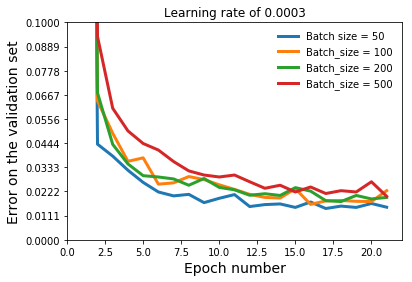

In [54]:
plt.figure(1)
plt.clf()
for bs in batch_sizes:
    plt.plot(range(1,max_num_of_epochs+2), Validation_error_dict1[ str(bs) ][0:22],'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error on the validation set',fontsize = 14)
plt.xlim(0,22)

plt.yticks(np.linspace(0,0.1,10))
plt.ylim(0,0.1)
plt.legend(['Batch size = 50','Batch_size = 100','Batch_size = 200',
           'Batch_size = 500'],frameon = False)
plt.title("Learning rate of 0.0003")
plt.show()

From now on we will use learning rate of 0.0003 and batch size of 50

In [55]:
lr = 0.0003
bs = 50
max_num_of_epochs = 10
sess = tf.InteractiveSession()
# Initializing all the variables
sess.run(tf.global_variables_initializer())
Validation_error_model1 = []
for i in range(int(max_num_of_epochs*data_train_length/bs)):
    x_batch, y_batch = create_minibatches(x_train, y_train_vector, bs, shuffle=True)
    sess.run(train_step, feed_dict={x: x_batch, y: y_batch, learning_rate: lr, batch_size: bs})
    if i%int(data_train_length/bs)==0:
        # Error for a training and validation set
        error_train = 1 - accuracy.eval(feed_dict={x: x_train, y: y_train_vector})
        error_valid = 1 - accuracy.eval(feed_dict={x: x_valid, y: y_valid_vector})
        print(error_train, error_valid)
        Validation_error_model1.append(error_valid)

0.868258535862 0.863254696131
0.060882627964 0.0636745095253
0.0346543192863 0.0404838323593
0.0249280929565 0.0320871472359
0.0205275416374 0.0294882059097
0.0156769752502 0.0243902206421
0.0144518017769 0.0232906937599
0.0159519910812 0.028088748455
0.0130266547203 0.0241903066635
0.00735092163086 0.018092751503
0.0065758228302 0.0188924670219


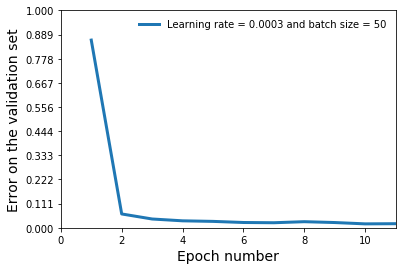

In [57]:
plt.figure(3)
plt.clf()
plt.plot(range(1,max_num_of_epochs+2), Validation_error_model1,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error on the validation set',fontsize = 14)
plt.xlim(0,11)

plt.yticks(np.linspace(0,1,10))
plt.ylim(0,1)
plt.legend(['Learning rate = 0.0003 and batch size = 50'],frameon = False)
plt.show()

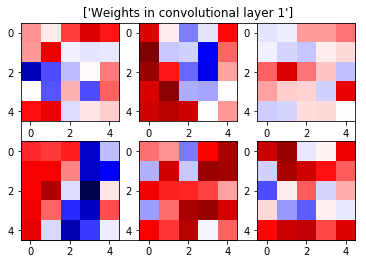

In [58]:
indices1 = plotting_filters_on_convolution_layer_1(W_conv1, 6, 7)

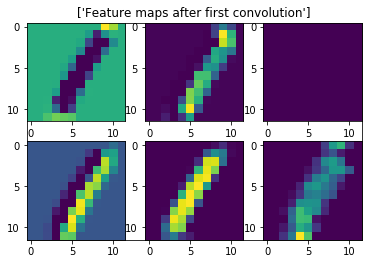

In [59]:
visualizing_feature_maps(output_conv_layer = output_conv_layer1, image = x_train[0], num_feature_maps_we_want_to_plot = 6, 
                         indices = indices1, figure_num = 8)

In [60]:
# Accuracy and error for a training dataset
print("Accuracy for a training set ", accuracy.eval(feed_dict={x: x_train, y: y_train_vector}), 
      "Error for a training set ", 1- accuracy.eval(feed_dict={x: x_train, y: y_train_vector}))
# Accuracy and error for a validation set
print("Accuracy for a validation set", accuracy.eval(feed_dict={x: x_valid, y: y_valid_vector}), 
      "Error for a validation set ", 1- accuracy.eval(feed_dict={x: x_valid, y: y_valid_vector}))
# Accuracy and error for a test set
print("Accuracy for a test set", accuracy.eval(feed_dict={x: x_test, y: y_test_vector}), 
      "Error for a test set ", 1- accuracy.eval(feed_dict={x: x_test, y: y_test_vector}))

Accuracy for a training set  0.993274 Error for a training set  0.0067258477211
Accuracy for a validation set 0.979908 Error for a validation set  0.0200919508934
Accuracy for a test set 0.980898 Error for a test set  0.0191019177437


In [61]:
sess.close()

## Second model with two convolutional layers and two fully connected layers

In [62]:
# Defining configuration of our neural network:

# Convolution layer 1
kernel_size1 = 5 
num_kernels1 = 6
stride_step1 = 1

# Convolution layer 2
kernel_size2 = 5 
num_kernels2 = 16
stride_step2 = 1

# Fully connected layers 
hidden_layer_size1 = 120       
hidden_layer_size2 = 80  

data_train_length = len(x_train)

In [63]:
# Reshaping the x vector into a tensor so that we can feed it to our convolutional layer which accepts only 
# 4 dimensional tensors
x_reshaped_as_image = tf.reshape(x, [-1,28,28,1])
        
output_conv_layer1, W_conv1_model2 = convolution_layer_builder(input = x_reshaped_as_image, kernel_size = kernel_size1,
                                                       num_kernels = num_kernels1, stride_step = stride_step1, 
                                                       num_inputs_channels = 1, scope_name = "W_conv1_model2")
#Adding the second convolutional layer to our model
output_conv_layer2, W_conv2_model2 = convolution_layer_builder(input = output_conv_layer1, kernel_size = kernel_size2,
                                                       num_kernels = num_kernels2, stride_step = stride_step2, 
                                                       num_inputs_channels = num_kernels1, scope_name = "W_conv2_model2")
        
output_conv_layer2_reshaped, total_num_features = reshaping_output_con_layer(output_conv_layer2)
# Adding fully connected layers
output_fc_layer1 = fully_connected_layer_builder(input = output_conv_layer2_reshaped, hidden_layer_size=hidden_layer_size1,
                                                         total_num_features = total_num_features, scope_name = "l1_model2")
output_fc_layer2 = fully_connected_layer_builder(input = output_fc_layer1, hidden_layer_size=hidden_layer_size2,
                                                         total_num_features = hidden_layer_size1, scope_name = "l2_model2")
#Initializing weights for the final layer
Theta2 = np.sqrt(2)*tf.get_variable("Theta2_model2", shape=[hidden_layer_size2,10],
                                        initializer=tf.contrib.layers.xavier_initializer())
b2 = np.sqrt(2)*tf.get_variable("b2_model2", shape=[10],initializer=tf.contrib.layers.xavier_initializer())
        
a3=tf.matmul(output_fc_layer2,Theta2) + b2
y_predicted = tf.nn.softmax(a3)
# Calculcating loss (cross entropy function)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=a3))

# Model training using Adam optimizer using learning rate of 0.0003
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_predicted,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Tensor("MaxPool_1:0", shape=(?, 12, 12, 6), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 4, 4, 16), dtype=float32)
Tensor("l1_model2/mul:0", shape=(256, 120), dtype=float32)
Tensor("l1_model2/mul_1:0", shape=(120,), dtype=float32)
Tensor("l2_model2/mul:0", shape=(120, 80), dtype=float32)
Tensor("l2_model2/mul_1:0", shape=(80,), dtype=float32)


In [64]:
lr = 0.0003
bs = 50
max_num_of_epochs = 10
sess = tf.InteractiveSession()
# Initializing all the variables
sess.run(tf.global_variables_initializer())
Validation_error_model2 = []
for i in range(int(max_num_of_epochs*data_train_length/bs)):
    x_batch, y_batch = create_minibatches(x_train, y_train_vector, bs, shuffle=True)
    sess.run(train_step, feed_dict={x: x_batch, y: y_batch,learning_rate: lr, batch_size: bs })
    if i%int(data_train_length/bs)==0:
        # Error for a training and validation set
        error_train = 1 - accuracy.eval(feed_dict={x: x_train, y: y_train_vector})
        error_valid = 1 - accuracy.eval(feed_dict={x: x_valid, y: y_valid_vector})
        print(error_train, error_valid)
        Validation_error_model2.append(error_valid)

0.898887358606 0.89914034307
0.0543068051338 0.0547780990601
0.0318539738655 0.0377848744392
0.023677945137 0.0289884209633
0.0172271728516 0.0239903926849
0.0132516622543 0.0194922089577
0.0137267112732 0.0212914943695
0.0142768025398 0.0226909518242
0.0102012753487 0.0193922519684
0.0104262828827 0.0174930095673
0.00940120220184 0.0178928375244


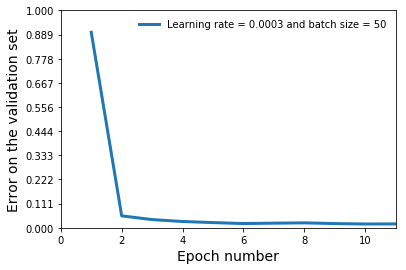

In [65]:
plt.figure(4)
plt.clf()
plt.plot(range(1,max_num_of_epochs+2), Validation_error_model2,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error on the validation set',fontsize = 14)
plt.xlim(0,11)

plt.yticks(np.linspace(0,1,10))
plt.ylim(0,1)
plt.legend(['Learning rate = 0.0003 and batch size = 50'],frameon = False)
plt.show()

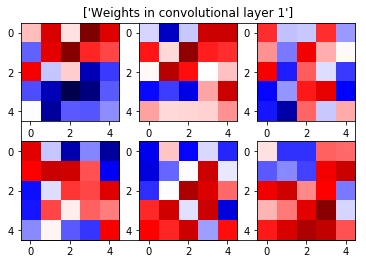

In [66]:
indices1 = plotting_filters_on_convolution_layer_1(W_conv1_model2, 6, figure_num =9)

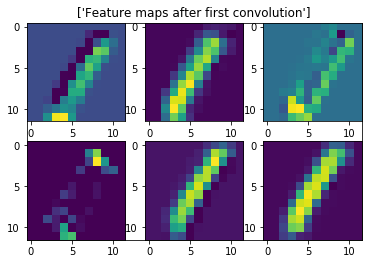

In [67]:
visualizing_feature_maps(output_conv_layer = output_conv_layer1, image = x_train[0], num_feature_maps_we_want_to_plot = 6, 
                         indices = indices1, figure_num = 10)

In [68]:
# Accuracy and error for a training dataset
print("Accuracy for a training set ", accuracy.eval(feed_dict={x: x_train, y: y_train_vector}), 
      "Error for a training set ", 1- accuracy.eval(feed_dict={x: x_train, y: y_train_vector}))
# Accuracy and error for a validation set
print("Accuracy for a validation set", accuracy.eval(feed_dict={x: x_valid, y: y_valid_vector}), 
      "Error for a validation set ", 1- accuracy.eval(feed_dict={x: x_valid, y: y_valid_vector}))
# Accuracy and error for a test set
print("Accuracy for a test set", accuracy.eval(feed_dict={x: x_test, y: y_test_vector}), 
      "Error for a test set ", 1- accuracy.eval(feed_dict={x: x_test, y: y_test_vector}))

Accuracy for a training set  0.991874 Error for a training set  0.00812602043152
Accuracy for a validation set 0.983207 Error for a validation set  0.0167933106422
Accuracy for a test set 0.984598 Error for a test set  0.0154015421867


In [69]:
sess.close()

## Third model with two convolutional layers and two fully connected layers

In [13]:
# Defining configuration of our neural network:

# Convolution layer 1
kernel_size1 = 5 
num_kernels1 = 32
stride_step1 = 1

# Convolution layer 2
kernel_size2 = 5 
num_kernels2 = 64
stride_step2 = 1

# Convolution layer 3
kernel_size3 = 1 
num_kernels3 = 128
stride_step3 = 1

# Fully connected layer 
hidden_layer_size1 = 1024       

data_train_length = len(x_train)

In [14]:
# Reshaping the x vector into a tensor so that we can feed it to our convolutional layer which accepts only 
# 4 dimensional tensors
x_reshaped_as_image = tf.reshape(x, [-1,28,28,1])
        
output_conv_layer1, W_conv1_model3 = convolution_layer_builder(input = x_reshaped_as_image, kernel_size = kernel_size1,
                                                       num_kernels = num_kernels1, stride_step = stride_step1, 
                                                       num_inputs_channels = 1, scope_name = "W_conv1_model3")
#Adding the second convolutional layer to our model
output_conv_layer2, W_conv2_model3 = convolution_layer_builder(input = output_conv_layer1, kernel_size = kernel_size2,
                                                       num_kernels = num_kernels2, stride_step = stride_step2, 
                                                       num_inputs_channels = num_kernels1, scope_name = "W_conv2_model3")
#Adding the third convolutional layer to our model
output_conv_layer3, W_conv3_model3 = convolution_layer_builder(input = output_conv_layer2, kernel_size = kernel_size3,
                                                       num_kernels = num_kernels3, stride_step = stride_step3, 
                                                       num_inputs_channels = num_kernels2, scope_name = "W_conv3_model3")
        
output_conv_layer3_reshaped, total_num_features = reshaping_output_con_layer(output_conv_layer3)
# Adding fully connected layers
output_fc_layer1 = fully_connected_layer_builder(input = output_conv_layer3_reshaped, hidden_layer_size=hidden_layer_size1,
                                                         total_num_features = total_num_features, scope_name = "l1_model3")

#Initializing weights for the final layer
Theta2_model3 = np.sqrt(2)*tf.get_variable("Theta2_model3", shape=[hidden_layer_size1,10],
                                        initializer=tf.contrib.layers.xavier_initializer())
b2_model3 = np.sqrt(2)*tf.get_variable("b2_model3", shape=[10],initializer=tf.contrib.layers.xavier_initializer())
        
a3=tf.matmul(output_fc_layer1,Theta2_model3) + b2_model3
y_predicted = tf.nn.softmax(a3)
# Calculcating loss (cross entropy function)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=a3))

# Model training using Adam optimizer using learning rate of 0.0003
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_predicted,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Tensor("MaxPool:0", shape=(?, 12, 12, 32), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 4, 4, 64), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 2, 2, 128), dtype=float32)
Tensor("l1_model3/mul:0", shape=(512, 1024), dtype=float32)
Tensor("l1_model3/mul_1:0", shape=(1024,), dtype=float32)


In [15]:
lr = 0.0003
bs = 50
max_num_of_epochs = 10
sess = tf.InteractiveSession()
# Initializing all the variables
sess.run(tf.global_variables_initializer())
Validation_error_model3 = []
for i in range(int(max_num_of_epochs*data_train_length/bs)):
    x_batch, y_batch = create_minibatches(x_train, y_train_vector, bs, shuffle=True)
    sess.run(train_step, feed_dict={x: x_batch, y: y_batch, learning_rate: lr, batch_size: bs})
    if i%int(data_train_length/bs)==0:
        # Error for a training and validation set
        error_train = 1 - accuracy.eval(feed_dict={x: x_train, y: y_train_vector})
        error_valid = 1 - accuracy.eval(feed_dict={x: x_valid, y: y_valid_vector})
        print(error_train, error_valid)
        Validation_error_model3.append(error_valid)

(0.90236279368400574, 0.90503798425197601)
(0.03510439395904541, 0.041183531284332275)
(0.014276802539825439, 0.019892036914825439)
(0.0087261199951171875, 0.014894068241119385)
(0.010276257991790771, 0.016293466091156006)
(0.0079510211944580078, 0.013994395732879639)
(0.0055257081985473633, 0.012095153331756592)
(0.0076759457588195801, 0.014894068241119385)
(0.0039004683494567871, 0.011695325374603271)
(0.0021502971649169922, 0.008996427059173584)
(0.0027003288269042969, 0.010595738887786865)


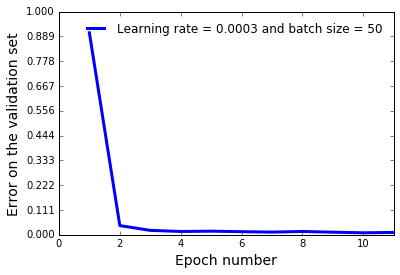

In [16]:
plt.figure(5)
plt.clf()
plt.plot(range(1,max_num_of_epochs+2), Validation_error_model3,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error on the validation set',fontsize = 14)
plt.xlim(0,11)

plt.yticks(np.linspace(0,1,10))
plt.ylim(0,1)
plt.legend(['Learning rate = 0.0003 and batch size = 50'],frameon = False)
plt.show()

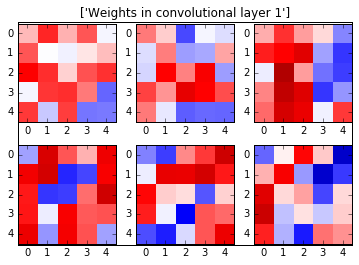

In [17]:
indices1 = plotting_filters_on_convolution_layer_1(W_conv1_model3, 6, figure_num =11)

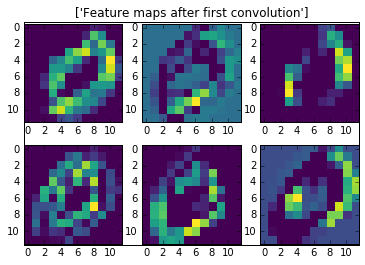

In [25]:
visualizing_feature_maps(output_conv_layer = output_conv_layer1, image = x_train[0], num_feature_maps_we_want_to_plot = 6, 
                         indices = indices1, figure_num = 12)

In [26]:
# Accuracy and error for a training dataset
print("Accuracy for a training set ", accuracy.eval(feed_dict={x: x_train, y: y_train_vector}), 
      "Error for a training set ", 1- accuracy.eval(feed_dict={x: x_train, y: y_train_vector}))
# Accuracy and error for a validation set
print("Accuracy for a validation set", accuracy.eval(feed_dict={x: x_valid, y: y_valid_vector}), 
      "Error for a validation set ", 1- accuracy.eval(feed_dict={x: x_valid, y: y_valid_vector}))
# Accuracy and error for a test set
print("Accuracy for a test set", accuracy.eval(feed_dict={x: x_test, y: y_test_vector}), 
      "Error for a test set ", 1- accuracy.eval(feed_dict={x: x_test, y: y_test_vector}))

('Accuracy for a training set ', 0.99654955, 'Error for a training set ', 0.0034504532814025879)
('Accuracy for a validation set', 0.9880048, 'Error for a validation set ', 0.011995196342468262)
('Accuracy for a test set', 0.99109912, 'Error for a test set ', 0.0089008808135986328)


In [20]:
sess.close()